## Multi Linear regression 적용 (investment Decision : multi linear regression 방법)
- Train 데이터로 학습된 xgboost로 Test 데이터 평가 -> Fully - Paid라고 확신하는 데이터 남겨둔다.
- Train 데이터로 학습된 regression 모델로 Fully - Paid라고 확신한 데이터 regression 진행
- 상위 10% 데이터를 이용하여 portfolio를 만든다.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [21]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [4]:
#Fake dataset
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

In [4]:
data.columns

Index(['last_fico_range_high', 'mo_sin_old_rev_tl_op', 'int_rate',
       'annual_inc', 'dti', 'installment', 'zip_code', 'revol_util',
       'fico_range_low', 'total_rev_hi_lim', 'revol_bal', 'bc_util',
       'avg_cur_bal', 'total_il_high_credit_limit', 'grade', 'total_pymnt',
       'total_pymnt_inv', 'loan_amnt', 'credit_history_years', 'term_months',
       'loan_status'],
      dtype='object')

In [22]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [23]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [19]:
data_y.value_counts()

loan_status
0              898669
1              217789
Name: count, dtype: int64

In [20]:
y_test.value_counts()

loan_status
0              599114
1              145192
Name: count, dtype: int64

In [24]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

# 1️⃣ XGBoost 모델 정의
model_base = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=1000,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.49195	validation_1-logloss:0.49198
[1]	validation_0-logloss:0.48735	validation_1-logloss:0.48740
[2]	validation_0-logloss:0.48287	validation_1-logloss:0.48294
[3]	validation_0-logloss:0.47852	validation_1-logloss:0.47860
[4]	validation_0-logloss:0.47427	validation_1-logloss:0.47438
[5]	validation_0-logloss:0.47013	validation_1-logloss:0.47026
[6]	validation_0-logloss:0.46610	validation_1-logloss:0.46624
[7]	validation_0-logloss:0.46217	validation_1-logloss:0.46233
[8]	validation_0-logloss:0.45833	validation_1-logloss:0.45851
[9]	validation_0-logloss:0.45459	validation_1-logloss:0.45478
[10]	validation_0-logloss:0.45093	validation_1-logloss:0.45114
[11]	validation_0-logloss:0.44735	validation_1-logloss:0.44758
[12]	validation_0-logloss:0.44386	validation_1-logloss:0.44411
[13]	validation_0-logloss:0.44044	validation_1-logloss:0.44071
[14]	validation_0-logloss:0.43710	validation_1-logloss:0.43738
[15]	validation_0-logloss:0.43384	validation_1-logloss:0.43413
[1

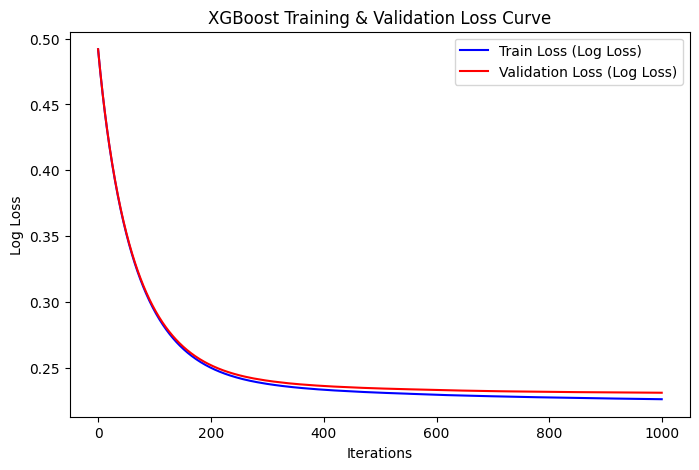

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94    599114
           1       0.74      0.75      0.75    145192

    accuracy                           0.90    744306
   macro avg       0.84      0.84      0.84    744306
weighted avg       0.90      0.90      0.90    744306



In [26]:
model_base.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model_base.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model_base.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

In [28]:
##Base Method에서 test_regression set 모으기.
fully_paid_indices = (y_pred == 0)

test_regression = test_data[fully_paid_indices]

test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['loan_amnt'])/test_regression['loan_amnt']
test_regression['return'].head(10)
#len(test_regression)

0     0.000939
2     0.147130
4     0.169867
5     0.596440
6     0.122451
7     0.029183
9     0.053438
11    0.184979
12    0.236543
13    0.198769
Name: return, dtype: float64

In [30]:
train_regression = data.copy()
train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']

In [ ]:
##drop feature
drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']

train_regression = train_regression.drop(columns=drop_features)
test_regression = test_regression.drop(columns=drop_features)

In [32]:
data_x = train_regression.drop(columns='return')
data_y = train_regression[['return']]

test_x = test_regression.drop(columns = 'return')
test_y = test_regression[['return']]

In [33]:
scaler = StandardScaler()

data_x_scaled = scaler.fit_transform(data_x)

X_train = data_x_scaled
y_train = data_y

test_x_scaled = scaler.transform(test_x)

### Multi - Linear regression

In [34]:
from sklearn.linear_model import Ridge,Lasso, ElasticNet

reg = LinearRegression()
#reg = Ridge(alpha=0.8)
#reg = Lasso(alpha=5)
reg.fit(X_train, y_train)

#print(reg.coef_)
y_pred = reg.predict(test_x_scaled)

print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
print("R²:", r2_score(test_y, y_pred))

test_regression['predicted_return'] = reg.predict(test_x_scaled)

top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))


RMSE: 0.19423627302025126
R²: -0.0002052464078345917


In [62]:
y_train.head()

,return
0,647.68
1,3441.12
2,559.08
3,-4665.08
4,1769.51


In [35]:
top_10_percent.head()

,last_fico_range_high,mo_sin_old_rev_tl_op,int_rate,annual_inc,dti,installment,zip_code,revol_util,fico_range_low,total_rev_hi_lim,revol_bal,bc_util,avg_cur_bal,total_il_high_credit_limit,loan_amnt,credit_history_years,return,predicted_return
118270,844.0,270.0,0.2170,80000.0,11.78,164.70,470.0,0.884,675.0,23500.0,20782.0,88.400000,22004.0,5000.0,6000.0,22,0.629347,0.500053
252198,659.0,186.0,0.1249,45000.0,14.67,117.08,918.0,8.923,695.0,300.0,2677.0,58.157757,2834.0,25644.0,3500.0,16,0.127046,0.496350
506401,834.0,199.0,0.2589,165000.0,1.90,756.60,330.0,0.973,660.0,8200.0,7976.0,97.200000,1595.0,0.0,25325.0,16,0.803952,0.493524
58016,834.0,197.0,0.2350,69000.0,10.24,444.27,923.0,0.962,665.0,14900.0,14330.0,96.200000,6846.0,29331.0,15600.0,16,0.568884,0.485926
465870,844.0,108.0,0.2220,92000.0,5.99,665.59,960.0,0.909,665.0,15600.0,14177.0,95.800000,30079.0,0.0,24000.0,21,0.537528,0.479123


## Portfolio 구성

In [37]:
portfolio = test_data.loc[top_10_percent.index].copy()

portfolio['actual_return'] = (portfolio['total_pymnt_inv'] - portfolio['loan_amnt'])/portfolio['loan_amnt']*100

mean_return = portfolio['actual_return'].mean()

std_return = portfolio['actual_return'].std()

sharpe_ratio = mean_return / std_return if std_return != 0 else np.nan

print(f"Average rate of return : {mean_return:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

Average rate of return : 18.4155
Sharpe Ratio: 1.4197


# 각 Method별 multi - lineara regression을 통한 portfolio 작성

In [47]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

#Fake dataset
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

In [48]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']

data_classification = data.copy()
test_classification = test_data.copy()
fake_Classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_Classification = fake_Classification.drop(columns = keep_features)

In [49]:
from imblearn.over_sampling import SMOTE
drop2 = ['loan_status', 'return']

def select_fully_paid(y_pred, method):
    scaler = StandardScaler()
    reg = LinearRegression()

    fully_paid_indices = (y_pred == 0)
    test_regression = test_data[fully_paid_indices]
    test_regression['return'] = (test_regression['total_pymnt_inv'] - test_regression['loan_amnt'])/test_regression['loan_amnt']

    train_regression = data.copy()

    if method == 'Base':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']

        drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        data_x = train_regression.drop(columns='return')
        data_y = train_regression[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))
        return method, top_10_percent
    
    elif method == 'Undersampling':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=X_train.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)

        data_x = data_under.drop(columns=drop2)  
        data_y = data_under[['return']]  

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)

        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
    
    elif method == 'SMOTE':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        X_train = train_regression.drop(columns='loan_status')
        y_train = train_regression[['loan_status']]

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        data_x = augmentation_data.drop(columns=drop2)
        data_y = augmentation_data[['return']]

        test_x = test_regression.drop(columns = drop2)
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

        return method, top_10_percent
    
    elif method == 'table-gan':
        train_regression['return'] = (train_regression['total_pymnt_inv'] - train_regression['loan_amnt'])/train_regression['loan_amnt']
        drop_features = ['loan_status', 'total_pymnt_inv', 'total_pymnt', 'grade', 'term_months']
        train_regression = train_regression.drop(columns=drop_features)
        test_regression = test_regression.drop(columns=drop_features)

        fake_regression = fake.copy()

        fake_regression['return'] = (fake_regression['total_pymnt_inv'] - fake_regression['loan_amnt'])/fake_regression['loan_amnt']
        fake_regression = fake_regression.drop(columns=drop_features)

        train_total = pd.concat([train_regression, fake_regression])

        data_x = train_total.drop(columns='return')
        data_y = train_total[['return']]

        test_x = test_regression.drop(columns = 'return')
        test_y = test_regression[['return']]

        data_x_scaled = scaler.fit_transform(data_x)

        X_train = data_x_scaled
        y_train = data_y

        test_x_scaled = scaler.transform(test_x)

        reg.fit(X_train, y_train)

        #print(reg.coef_)
        y_pred = reg.predict(test_x_scaled)

        print("RMSE:", mean_squared_error(test_y, y_pred, squared=False))
        print("R²:", r2_score(test_y, y_pred))

        test_regression['predicted_return'] = reg.predict(test_x_scaled)
        top_10_percent = test_regression.sort_values(by='predicted_return', ascending=False).head(int(len(test_regression)*0.1))

    return method, top_10_percent    

In [50]:
summary_with_sharpe = []

def linear_portfolio(Method, top_10_indices):
    selected = test_data.loc[top_10_indices.index].copy()
    returns = (selected['total_pymnt_inv'] - selected['loan_amnt']) / selected['loan_amnt']
    
    avg_return = returns.mean()
    std_return = returns.std()
    sharpe_ratio = avg_return / std_return if std_return != 0 else np.nan

    summary_with_sharpe.append({
        'Method': Method,
        'Average Return': avg_return * 100,
        'Std Dev': std_return,
        'Sharpe Ratio': sharpe_ratio
    }) 

In [51]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

def return_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)


    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    #10% index뽑기기
    Method, top_10_indices = select_fully_paid(y_pred, method)

    #portfolio 만들기들기
    linear_portfolio(Method, top_10_indices)

In [52]:
Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan']

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

for method in Methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = XGBClassifier(
        n_estimators=1000,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    return_evaluation(model, data_x, data_y, X_test, y_test, method)

returns_with_sharpe_df = pd.DataFrame(summary_with_sharpe)

print(returns_with_sharpe_df.to_string(index=False))

Preprocessing method : Base
[0]	validation_0-logloss:0.49195	validation_1-logloss:0.49198
[1]	validation_0-logloss:0.48735	validation_1-logloss:0.48740
[2]	validation_0-logloss:0.48287	validation_1-logloss:0.48294
[3]	validation_0-logloss:0.47852	validation_1-logloss:0.47860
[4]	validation_0-logloss:0.47427	validation_1-logloss:0.47438
[5]	validation_0-logloss:0.47013	validation_1-logloss:0.47026
[6]	validation_0-logloss:0.46610	validation_1-logloss:0.46624
[7]	validation_0-logloss:0.46217	validation_1-logloss:0.46233
[8]	validation_0-logloss:0.45833	validation_1-logloss:0.45851
[9]	validation_0-logloss:0.45459	validation_1-logloss:0.45478
[10]	validation_0-logloss:0.45093	validation_1-logloss:0.45114
[11]	validation_0-logloss:0.44735	validation_1-logloss:0.44758
[12]	validation_0-logloss:0.44386	validation_1-logloss:0.44411
[13]	validation_0-logloss:0.44044	validation_1-logloss:0.44071
[14]	validation_0-logloss:0.43710	validation_1-logloss:0.43738
[15]	validation_0-logloss:0.43384	val

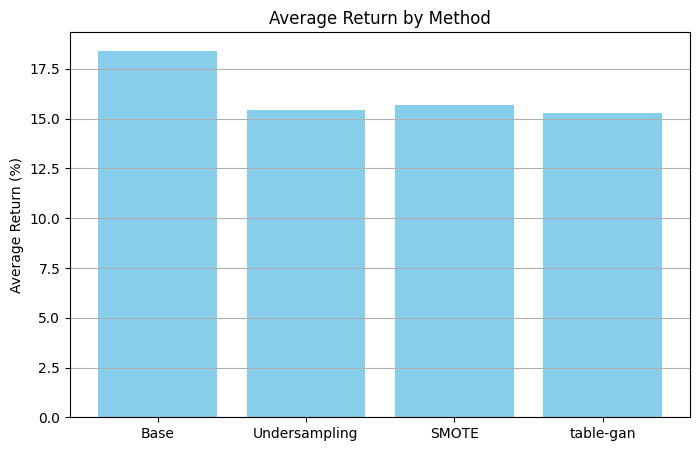

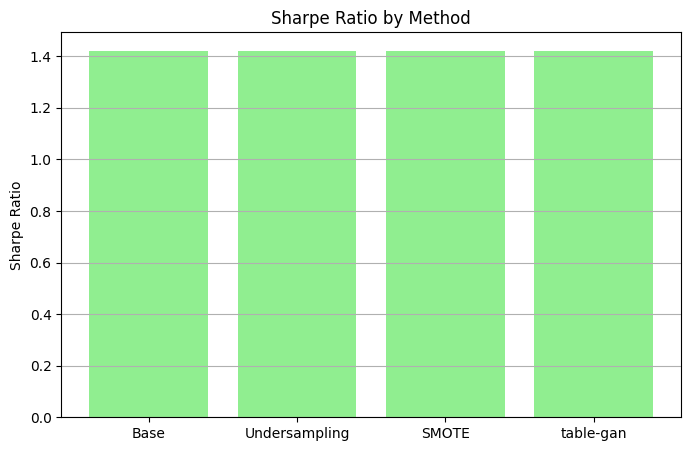

In [53]:
import matplotlib.pyplot as plt

methods = returns_with_sharpe_df['Method']
avg_returns = returns_with_sharpe_df['Average Return']
sharpe_ratios = returns_with_sharpe_df['Sharpe Ratio']

plt.figure(figsize=(8, 5))
plt.bar(methods, avg_returns, color='skyblue')
plt.ylabel("Average Return (%)")
plt.title("Average Return by Method")
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(methods, sharpe_ratios, color='lightgreen')
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio by Method")
plt.grid(axis='y')
plt.show()
